<a href="https://colab.research.google.com/github/Tsimiovalaza/Tiny-Machine-Learning-for-Home-Appliances/blob/main/Keras_and_Post_training_Quantization_with_WHITED_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://nextcloud.in.tum.de/index.php/s/bcJ5A8tFAZ7s5S3/download/WHITEDv1.1.zip
!mkdir whited
!unzip /content/WHITEDv1.1.zip -d whited
!cat whited/_readme.txt

--2022-03-04 11:28:35--  https://nextcloud.in.tum.de/index.php/s/bcJ5A8tFAZ7s5S3/download/WHITEDv1.1.zip
Resolving nextcloud.in.tum.de (nextcloud.in.tum.de)... 131.159.0.29
Connecting to nextcloud.in.tum.de (nextcloud.in.tum.de)|131.159.0.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824627541 (786M) [application/zip]
Saving to: ‘WHITEDv1.1.zip’

WHITEDv1.1.zip      100%[===================>] 786.43M  11.4MB/s    in 73s     

2022-03-04 11:29:50 (10.7 MB/s) - ‘WHITEDv1.1.zip’ saved [824627541/824627541]

Archive:  /content/WHITEDv1.1.zip
  inflating: whited/AC_Electrolux_r5_MK2_20151031065948.flac  
  inflating: whited/AC_Electrolux_r5_MK2_20151031070257.flac  
  inflating: whited/AC_Electrolux_r5_MK2_20151031070606.flac  
  inflating: whited/AC_Electrolux_r5_MK2_20151031070919.flac  
  inflating: whited/AC_Electrolux_r5_MK2_20151031071229.flac  
  inflating: whited/AC_Electrolux_r5_MK2_20151031071715.flac  
  inflating: whited/AC_Electrolux_r5_MK2_201510

In [ ]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal
import pandas as pd
import soundfile as sf
from scipy.signal import find_peaks
from scipy.signal import resample
from sklearn.metrics import confusion_matrix
import itertools
import cv2

SAMPLING_RATE = 8000
WIN_LEN=int( 0.012 * SAMPLING_RATE) # 25ms window
HOP_LEN=int( 0.006 * SAMPLING_RATE) # 10ms hop
N_MELS=64
N_FFT=512
FRAME_WIN=64
FRAME_HOP=8

def ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate=8000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        #print("resample",original_sample_rate,desired_sample_rate)
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = resample(waveform, desired_length)
    return desired_sample_rate, waveform

def extract_logmelspecs(wav_filename):
  samples, sample_rate = sf.read(wav_filename)
  #_ , waveform = ensure_sample_rate(sample_rate,samples[8820:44100,1],SAMPLING_RATE) #startup phase
  _ , waveform = ensure_sample_rate(sample_rate,samples[44100:,1],SAMPLING_RATE) #permanent phase
  # win 25ms hop 10ms
  S_current = librosa.feature.melspectrogram(y=waveform, sr=SAMPLING_RATE, S=None, n_fft=N_FFT, win_length=WIN_LEN, hop_length=HOP_LEN, window='hann', n_mels=N_MELS)
  log_S_curr = librosa.power_to_db(S_current, ref=np.max)
  frames_current = librosa.util.frame(log_S_curr.T, frame_length=FRAME_WIN, hop_length=FRAME_HOP,axis=0)
  return frames_current

def extract_logmelspecs_volt(wav_filename):
  samples, sample_rate = sf.read(wav_filename)
  #_ , waveform1 = ensure_sample_rate(sample_rate,samples[8820:44100,0],SAMPLING_RATE) #startup phase
  _ , waveform1 = ensure_sample_rate(sample_rate,samples[44100:,0],SAMPLING_RATE) #permanent phase
  S_voltage = librosa.feature.melspectrogram(y=waveform1, sr=SAMPLING_RATE, S=None, n_fft=N_FFT, win_length=WIN_LEN, hop_length=HOP_LEN, window='hann', n_mels=N_MELS)
  log_S_volt = librosa.power_to_db(S_voltage, ref=np.max)
  frames_voltage = librosa.util.frame(log_S_volt.T, frame_length=FRAME_WIN, hop_length=FRAME_HOP,axis=0)
  return frames_voltage

#Counts data by voltage range MK1 / MK2 / MK3

In [ ]:
import numpy as np
import glob
flacs = glob.glob('whited/*.flac')
mk1 = []
mk2 = []
mk3 = []
for f in flacs:
  if "_MK1_" in f:
    mk1.append( f )
  if "_MK2_" in f:
    mk2.append( f )
  if "_MK3_" in f:
    mk3.append( f )

print("mk1:",len(mk1), "mk2:",len(mk2),"mk3:",len(mk3))

mk1: 320 mk2: 1019 mk3: 0


#Fetch appliance names by voltage/current factor

In [ ]:
factors = "_MK2_"
for f in flacs:
  if factors in f:
    print( f.split(factors)[0][7:-3] )

DeepFryer_Kueche1500W
LaserPrinter_BrotherHL1450
DesktopPC_300W
PowerSupply_BaseTechBT305
LEDLight_FLRGB
Fan_VOV-50W
CoffeeMachine_AlaskaCM2209m
Monitor_DellU2713H
Charger_SamsungTravelAdapter1A
SolderingIron_80W
LEDLight_MH300
GameConsole_SegaMegaDrive
GameConsole_PS1
Treadmill_Shaga
CFL_IKEA15W
Hairdryer_Valera54206
FlatIron_PhilipsA
LightBulb_Osram25W
Toaster_Electrolux
HairDryer_RemingtonD5000
DesktopPC_300W
Kettle_IdeenWelt
Shredder_Quigg190W
Iron_Philips-GC1990
LaserPrinter_BrotherHL1450
SewingMachine_Veritas
CoffeeMachine_AlaskaCM2209m
TV_Philips-42pfl3403
LEDLight_A
Iron_Philips-GC1990
Microwave_Privileg8020
Iron_PanasonicNIB36TS
Iron_Philips-GC1990
FlatIron_PhilipsB
Iron_PanasonicNIB36TS
LightBulb_Tungsten-40W
HairDryer_Tedi
HairDryer_Tedi
JuiceMaker_PowerJuicer
LEDLight_A
GameConsole_PS1
Iron_Clatronic1200W
Fan_Krisbow50W
Iron_AFK1800W
WaterHeater_Daalderop
ShoeWarmer_Enka
DrillingMachine_ProWorkSMJ500e
ShoeWarmer_ThermIc
Kettle_IdeenWelt
Treadmill_Shaga
FlatIron_PhilipsA
Shr

#Fetch appliance names by voltage/current factor (listed by type)

In [ ]:
factors = "_MK2_"
counters = {}
for f in flacs:
  if factors in f:
    app_type = f.split(factors)[0][7:-3].split('_')[0]
    if app_type in counters:
      counters[app_type] += 1
    else:
      counters[app_type] = 1

for w in sorted(counters, key=counters.get, reverse=True):
  print("Appliance type",w,"has ",counters[w],"acquisition")

Appliance type LEDLight has  90 acquisition
Appliance type Charger has  70 acquisition
Appliance type Kettle has  69 acquisition
Appliance type LightBulb has  60 acquisition
Appliance type Iron has  50 acquisition
Appliance type PowerSupply has  40 acquisition
Appliance type Fan has  40 acquisition
Appliance type GameConsole has  40 acquisition
Appliance type Toaster has  40 acquisition
Appliance type HairDryer has  40 acquisition
Appliance type Mixer has  40 acquisition
Appliance type TV has  30 acquisition
Appliance type Massage has  30 acquisition
Appliance type Monitor has  20 acquisition
Appliance type SolderingIron has  20 acquisition
Appliance type FlatIron has  20 acquisition
Appliance type Shredder has  20 acquisition
Appliance type Microwave has  20 acquisition
Appliance type ShoeWarmer has  20 acquisition
Appliance type VacuumCleaner has  20 acquisition
Appliance type DeepFryer has  10 acquisition
Appliance type LaserPrinter has  10 acquisition
Appliance type DesktopPC has  

#Data augmentation

In [ ]:
def log_mel_pitch_tuning(wavfile):
  y_speed, sr = samples, sample_rate = sf.read(wavfile)
  _ , y_pitch = ensure_sample_rate(sr,y_speed[44100:,1],SAMPLING_RATE)
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2*(np.random.uniform())
  y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
  #log_mel spectrogram computation
  S_current = librosa.feature.melspectrogram(y=y_pitch, sr=SAMPLING_RATE, S=None, n_fft=N_FFT, win_length=WIN_LEN, hop_length=HOP_LEN, window='hann', n_mels=N_MELS)
  log_S_curr = librosa.power_to_db(S_current, ref=np.max)
  frames_current = librosa.util.frame(log_S_curr.T, frame_length=FRAME_WIN, hop_length=FRAME_HOP,axis=0)
  return frames_current

In [ ]:
def log_mel_speed_tuning(wavfile):
  y_speed, sr = samples, sample_rate = sf.read(wavfile)
  _ , y_speed = ensure_sample_rate(sr,y_speed[44100:,1],SAMPLING_RATE)
  speed_change = np.random.uniform(low=0.9,high=1.1)
  tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
  minlen = min(y_speed.shape[0], tmp.shape[0])
  y_speed *= 0 
  y_speed[0:minlen] = tmp[0:minlen] #speed tuning
  #log_mel spectrogram computation
  S_current = librosa.feature.melspectrogram(y=y_speed, sr=SAMPLING_RATE, S=None, n_fft=N_FFT, win_length=WIN_LEN, hop_length=HOP_LEN, window='hann', n_mels=N_MELS)
  log_S_curr = librosa.power_to_db(S_current, ref=np.max)
  frames_current = librosa.util.frame(log_S_curr.T, frame_length=FRAME_WIN, hop_length=FRAME_HOP,axis=0)
  return frames_current

#Create dataset using current data for 31 appliances using audio augmentation

In [ ]:
SAMPLING_RATE = 8000
CLASSES_10 = {'Halogen':0,'AC':1,'JuiceMaker':2,'HIFI':3,'WashingMachine':4,'HalogenFluter':5,
           'DesktopPC':6,'SewingMachine':7,'Hairdryer':8,'Desoldering':9,'DrillingMachine':10,
           'DeepFryer':11,'CoffeeMachine':12,'FanHeater':13,'MultiTool':14,'WaterHeater':15,
           'BenchGrinder':16,'Treadmill':17,'GuitarAmp':18,'JigSaw':19,'WaterPump':20,'CFL':21,'MosquitoRepellent':22,'LaserPrinter':23}
CLASSES_20 = {'FlatIron':24,'SolderingIron':25,'ShoeWarmer':26,'Monitor':27,'Microwave':28,'Shredder':29,'VacuumCleaner':30}
CLASSES_30 = {'Massage':31,'TV':32}
CLASSES_40 = {'HairDryer':33,'Toaster':34,'GameConsole':35,'PowerSupply':36,'Mixer':37,'Fan':38}
CLASSES_50 = {'Iron':39}
CLASSES_60 = {'LightBulb':40}
CLASSES_70 = {'Kettle':41,'Charger':42}
CLASSES_90 = {'LEDLight':43}
factors = "_MK2_"
x=[]
y=[]
counters=np.zeros(31)
#counters=np.zeros(2)
for f in flacs:
  if factors in f:
    app_type = f.split(factors)[0][7:-3].split('_')[0]
    if app_type in CLASSES_10:
      cu_frames = extract_logmelspecs(f)
      cu_frames_speed_chg_10_1 = log_mel_speed_tuning(f)
      #vo_frames = extract_logmelspecs_volt(f)
      for i in range(len(cu_frames)):
        #frame = cv2.merge((cu_frames[0][i], vo_frames[i]))
        frame = cu_frames[i]
        #frame = np.reshape(frame,(4096)) #for DNN and SVC
        x.append( frame )
        y.append( CLASSES_10[app_type] )
        counters[ CLASSES_10[app_type] ] += 1
      for i in range(len(cu_frames_speed_chg_10_1)):
        #frame = cv2.merge((cu_frames[0][i], vo_frames[i]))
        frame_spd1 = cu_frames_speed_chg_10_1[i]
        #frame_spd1 = np.reshape(frame_spd1,(4096)) #for DNN and SVC
        x.append( frame_spd1 )
        y.append( CLASSES_10[app_type] )
        counters[ CLASSES_10[app_type] ] += 1     
    if app_type in CLASSES_20:
      cu_frames1 = extract_logmelspecs(f)
      #vo_frames = extract_logmelspecs_volt(f)
      for i in range(len(cu_frames1)):
        #frame = cv2.merge((cu_frames[0][i], vo_frames[i]))
        frame1 = cu_frames1[i]
        #frame1 = np.reshape(frame1,(4096)) #for DNN and SVC
        x.append( frame1 )
        y.append( CLASSES_20[app_type] )
        counters[ CLASSES_20[app_type] ] += 1

print( counters )
print(cu_frames[1].shape)
np.savez("ds_8000Hz_MK2.npz",x=x,y=y)





/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:206: UserWarning: librosa.util.frame called with axis=0 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)
/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:206: UserWarning: librosa.util.frame called with axis=0 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)
/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:206: UserWarning: librosa.util.frame called with axis=0 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


[1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560.
 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560. 1560.
 1560. 1560. 1560. 1560. 1560. 1560. 1560.]
(64, 64)


In [ ]:
!pip install tensorflow==2.7.0
!pip install keras==2.6.0

     |████████████████████████████████| 489.6 MB 21 kB/s 
     |████████████████████████████████| 463 kB 48.8 MB/s 
     |████████████████████████████████| 1.3 MB 42.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


     |████████████████████████████████| 1.3 MB 4.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.6.0 which is incompatible.


#Training and testing with keras 

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
import numpy as np
import os

acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

def cnn(x_train,y_train,x_test,y_test):

  i = tf.keras.Input(shape = (64, 64))
  x = tf.keras.layers.Reshape(target_shape=(64, 64, 1))(i)
  x = tf.keras.layers.Conv2D(8, (3, 3),padding="same")(x)
  x = tf.keras.layers.MaxPooling2D((3,3))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(x)
  x = tf.keras.layers.MaxPooling2D((3, 3), padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(x)
  x = tf.keras.layers.MaxPooling2D((3, 3), padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(31)(x)
  o = tf.keras.layers.Activation("softmax")(x)

  model = tf.keras.Model(inputs=i, outputs=o)
  model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
  model.summary()

  t_history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)
  test_scores = model.evaluate(x_test, y_test, verbose=2)
  y_test_per_fold.append(y_test)
  y_pred = model.predict(x_test)
  y_pred_per_fold.append(y_pred)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])
  acc_per_fold.append(test_scores[1] * 100)
  loss_per_fold.append(test_scores[0])
  return model, t_history, test_scores[1]

ds = np.load("ds_8000Hz_MK2.npz")
prev_test_score = 0

kf=KFold(n_splits=5, random_state=2021, shuffle=True)
for train_index, test_index in kf.split( ds['x'] ):
  x_train, x_test = ds['x'][train_index], ds['x'][test_index]
  y_train, y_test = ds['y'][train_index], ds['y'][test_index]
  print(x_train.shape)
  cnn_model = cnn(x_train,y_train,x_test,y_test)
  best_accuracy = cnn_model[2]
  if best_accuracy>=prev_test_score:
    prev_test_score = best_accuracy
    best_model = cnn_model

(38688, 64, 64)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 21, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 21, 21, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


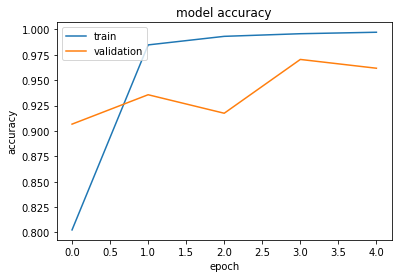

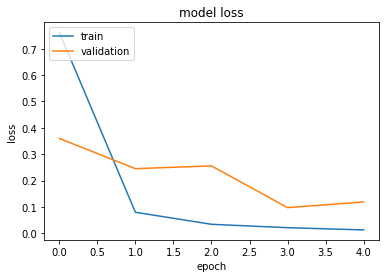

In [ ]:
import matplotlib.pyplot as plt
history = best_model[1]  #the model trained with the last fold
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
best_model[0].summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 21, 21, 8)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 21, 21, 8)         32        
_________________________________________________________________
activation_16 (Activation)   (None, 21, 21, 8)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 21, 21, 8)         0   

In [ ]:
#Average accuracy of the test 
print(acc_per_fold)
print("The average accuracy through the 5 folds is: ",np.mean(acc_per_fold))

[95.48180103302002, 98.02522659301758, 98.3250617980957, 97.5806474685669, 99.22456741333008]
The average accuracy through the 5 folds is:  97.72746086120605


In [ ]:
best_model[0].save("CNN_WHITED"+".h5")

from google.colab import files
files.download("./CNN_WHITED.h5")  #Download file

tf.saved_model.save(best_model[0], "saved_model_keras_dir") #for the post-training quantization purpose

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: saved_model_keras_dir/assets


#Post training quantization

In [ ]:
ds = np.load("ds_8000Hz_MK2.npz")
x_train = ds['x'][1:500]

import tensorflow as tf
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [tf.dtypes.cast(x_train, tf.float32)]
    

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_keras_dir')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

with open('CNN_QUANTIZED_WHITED.tflite', 'wb') as f:
  f.write(tflite_model_quant)

from google.colab import files
files.download("./CNN_QUANTIZED_WHITED.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Compare KERAS and POST-TRAINING QUANTIZED KERAS

In [ ]:
# model relative path
path_models = "./"
path_keras_model = path_models + "CNN_WHITED.h5" # path keras model
path_tflite_model = path_models + "CNN_QUANTIZED_WHITED.tflite" # path tensorflow quantized 8bit model

from numpy.core.fromnumeric import argmax
from sklearn.metrics import accuracy_score
from tensorflow import keras



#print size of Keras and TFLite saved model
print("Keras model size: "+str(os.path.getsize(path_keras_model))+"Bytes")
print("TFlite model size: "+str(os.path.getsize(path_tflite_model))+"Bytes")
print("TFLite model is {:.2f}".format(os.path.getsize(path_keras_model)/os.path.getsize(path_tflite_model))+" times lower than Keras model")


# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file,x_test,y_test, test_mps_indices):
  
  test_mpss = x_test
  test_labels = y_test
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  print(input_details)
  output_details = interpreter.get_output_details()[0]
  print(output_details)

  predictions = np.zeros((len(test_mps_indices),), dtype=int)
  for i, test_mps_index in enumerate(test_mps_indices):
    test_mps = test_mpss[test_mps_index]
    test_label = test_labels[test_mps_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_mps = test_mps / input_scale + input_zero_point

    test_mps = np.expand_dims(test_mps, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_mps)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


# Helper function to evaluate a TFLite model on all input
def evaluate_model(tflite_file, x_test,y_test,model_type):

  test_mpss = x_test

  test_labels = y_test
  test_mps_indices = range(test_mpss.shape[0])
  predictions = run_tflite_model(tflite_file, test_mpss,test_labels, test_mps_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_mpss)

  return accuracy
  

#Testing the models through 5 folds

from sklearn.model_selection import KFold
import tensorflow as tf

ds = np.load("ds_8000Hz_MK2.npz")
Acc_per_fold_TFlite = []
Acc_per_fold_Keras = []
model = keras.models.load_model(path_keras_model)

kf=KFold(n_splits=5, random_state=1000, shuffle=True)
for train_index, test_index in kf.split( ds['x'] ):
  x_train, x_test = ds['x'][train_index], ds['x'][test_index]
  y_train, y_test = ds['y'][train_index], ds['y'][test_index]
  accuracy_tflite = evaluate_model("CNN_QUANTIZED_WHITED.tflite",x_test, y_test, model_type="Quantized")
  Acc_per_fold_TFlite.append(accuracy_tflite)
  accuracy_keras = model.evaluate(x_test, y_test)
  Acc_per_fold_Keras.append(accuracy_keras[1])

#Average of the test
print("TFLITE average accuracy through the 5 folds: ",np.mean(Acc_per_fold_TFlite))
print("Keras average accuracy through the 5 folds: ",np.mean(Acc_per_fold_Keras)*100)

Keras model size: 263312Bytes
TFlite model size: 24080Bytes
TFLite model is 10.93 times lower than Keras model
{'name': 'serving_default_input_5:0', 'index': 0, 'shape': array([ 1, 64, 64], dtype=int32), 'shape_signature': array([-1, 64, 64], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.3137255012989044, 255), 'quantization_parameters': {'scales': array([0.3137255], dtype=float32), 'zero_points': array([255], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 40, 'shape': array([ 1, 31], dtype=int32), 'shape_signature': array([-1, 31], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
303/303 [==============================] - 8s 25ms/step - loss: 0.0248 - accuracy: 0.9938
{'name': 'serving_default_input_5:0',